In [1]:
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [2]:
import pandas as pd
df = pd.read_csv("train.csv")

In [62]:
def dia_semana(numero):
    dias = {
        0: 'Lunes',
        1: 'Martes',
        2: 'Miercoles',
        3: 'Jueves',
        4: 'Viernes',
        5: 'Sabado',
        6: 'Domingo'
    }
    
    return dias.get(numero)

In [3]:
def normalizar_descripciones(descripcion):
    
    descripcion = descripcion.replace(',', ' ')
    descripcion = descripcion.replace('.', ' ')
    descripcion = descripcion.replace('<', ' ')
    descripcion = descripcion.replace('>', ' ')
    descripcion = descripcion.replace('\n', ' ')
    descripcion = descripcion.replace('\strong', ' ')
    descripcion = descripcion.replace('\bold', ' ')
    descripcion = descripcion.lower()
    
    return descripcion

def contar_palabras(titulo, palabras):
    
    contadas = 0
    spliteado = titulo.split()
    
    for palabra in palabras:
        contadas += spliteado.count(palabra)
        
    return contadas

def contar_frases(columna, frases):
    
    contadas = 0
    
    for frase in frases:
        
        contadas += columna.count(frase)
        
    return contadas

In [4]:
DIRINVALIDAS = set(['Calle','domicilio conocido','calle','CALLE','--','Sin nombre ','1','.','-','x #x','0','...','S/N'])


df.loc[df.direccion.isin(DIRINVALIDAS), 'direccion'] = 0
df.loc[df['direccion'] != 0, 'direccion'] = 1

df['titulo'] = df['titulo'].fillna(value = ".")
df['titulo'] = df['titulo'].apply(normalizar_descripciones)
df['descripcion'] = df['descripcion'].fillna(value = ".")
df['descripcion'] = df['descripcion'].apply(normalizar_descripciones)

df['fecha'] = pd.to_datetime(df['fecha'])

In [5]:
df['avenida'] = df['titulo'].apply(contar_palabras, palabras=["avenida", "av", "avenidas", "bulevar", 
               "boulevard", "paseo", "vía"])+df['descripcion'].apply(contar_palabras, palabras=["avenida", "av", 
                "avenidas", "bulevar","boulevard", "paseo", "vía"])

df['gim'] = df['titulo'].apply(contar_palabras, palabras=["gimnasio", "gimnásio", "entrenamiento", "gim", "gym", "fit",
            "ejercicio", "gimnasia","atletismo", "cancha"])+df['descripcion'].apply(contar_palabras, palabras=["gimnasio",
            "gimnásio", "entrenamiento", "gim", "gym", "fit","ejercicio", "gimnasia","atletismo", "cancha"])

df['pileta'] = df['titulo'].apply(contar_palabras, palabras=["piscina", "pileta", "nado"])+ df['descripcion'].apply(contar_palabras, palabras=["piscina", "pileta", "nado"])
                                       
df['lujo'] = df['titulo'].apply(contar_palabras, palabras=["lujo", "delujo", "deluxe", "delúxe", "lujosa", "lujoso", 
            "lujosas", "lujosos","exclusivo","vip"]) + df['descripcion'].apply(contar_palabras, palabras=["lujo", 
            "delujo","deluxe", "delúxe", "lujosa", "lujoso", "lujosas", "lujosos","exclusivo","vip"])

df['humilde'] = df['titulo'].apply(contar_palabras, palabras=["humilde", "economico", "economica", 
            "económico", "económica", "barata", "barato", "accesible", "baratillo",
            "baratilla", "rebajado", "ganga", "asequible", "módico", "módica","credito","crédito","oferta","oferton",
            "imperdible"]) + df['descripcion'].apply(contar_palabras, palabras=["humilde", "economico", "economica", 
            "económico", "económica", "barata", "barato", "accesible", "baratillo",
            "baratilla", "rebajado", "ganga", "asequible", "módico", "módica",
            "credito","crédito","oferta","oferton","imperdible"]) 

df['ventana'] = df['titulo'].apply(contar_palabras, palabras=["ventana", "ventanas", 
            "vista", "ventanal","vistas","cristal"]) + df['descripcion'].apply(contar_palabras, palabras=["ventana",
            "ventanas", "vista", "ventanal","vistas","cristal"])

df['contable'] = df['titulo'].apply(contar_palabras, palabras=["precio"]) + df['descripcion'].apply(contar_palabras, palabras=["precio"])

#Nuevos Feat

df['agente'] = df['descripcion'].apply(contar_palabras, palabras=["inmobiliaria", "asesoria", "asesoría", "lider", "re/max", "remax"]) \
             + df['titulo'].apply(contar_palabras, palabras=["inmobiliaria", "asesoria", "asesoría", "lider", "re/max", "remax"])

df['garante'] = df['descripcion'].apply(contar_palabras, palabras=["garante", "garantía", "fiador", "garantizador", "avalista", "garantia",
                "defensor", "garantías", "garantes", "codeudor"]) + df['titulo'].apply(contar_palabras, palabras=["garante", 
                "garantía", "fiador", "garantizador", "avalista", "garantia", "defensor", "garantías", "garantes", "codeudor"])

df['finanza'] =  df['descripcion'].apply(contar_palabras, palabras=["credito", "crédito", "prestamo", "préstamo", "cuotas", "pagos", "hipotecario"\
                 ,"amortizable", "aptocredito", "aptocrédito", "apto-credito", "apto-crédito", "aptocredito", "aptocréditp", "ahorro"]) + \
                 df['titulo'].apply(contar_palabras, palabras=["credito", "crédito", "prestamo", "préstamo", "cuotas", "pagos", "hipotecario" \
                 ,"amortizable", "aptocredito", "aptocrédito", "apto-credito", "apto-crédito", "aptocredito", "aptocrédito", "ahorro"]) 

df['turismo'] =  df['descripcion'].apply(contar_palabras, palabras=["playa", "vacaciones", "descanso", "costa", "arena", "mar", "montaña", "monte",
                                                                   "paisaje", "orilla", "rambla", "turista", "turistas", "cordillera", "sierra"])\
                 + df['titulo'].apply(contar_palabras, palabras=["playa", "vacaciones", "descanso", "costa", "arena", "mar", "montaña", "monte",
                                                                   "paisaje", "orilla", "rambla", "turista", "turistas", "cordillera", "sierra"])

df['normas'] =  df['descripcion'].apply(contar_palabras, palabras=["norma", "normas", "regla", "reglas", \
                                                "prohibido", "prohibida", "denegado", "denegada", "imposible", \
                                                "ilegal", "legal", "multa", "infraccion", "infracción"])\
                 + df['titulo'].apply(contar_palabras, palabras=["norma", "normas", "regla", "reglas", \
                                                "prohibido", "prohibida", "denegado", "denegada", "imposible", \
                                                "ilegal", "legal", "multa", "infraccion", "infracción"])

df['conexion'] = df['descripcion'].apply(contar_palabras, palabras=["wifi", "wi-fi", "internet", "conexión", "conexion", \
                                                                   "señal"])\
                 + df['titulo'].apply(contar_palabras, palabras=["wifi", "wi-fi", "internet", "conexión", "conexion", \
                                                                   "señal"])

df['acabados'] = df['descripcion'].apply(contar_palabras, palabras = ["acabados","acabado","terminacion","terminación"])

#Nuevos de V5

df['alberca'] = df['descripcion'].apply(contar_palabras, palabras=['alberca'])

df['negacion'] = df['descripcion'].apply(contar_palabras, palabras = ["no"])

df['vestidor'] = df['descripcion'].apply(contar_palabras, palabras = ["vestidor"])

#Nuevos de V7

df['popularidad'] = df['descripcion'].apply(contar_palabras, palabras=["popular", "famoso", "famosa", "famosos", "populares", \
                                                        "conocido", "conocida", "conocidos"])\
                 + df['titulo'].apply(contar_palabras, palabras=["popular", "famoso", "famosa", "famosos", "populares", \
                                                        "conocido", "conocida", "conocidos"])

df['dueño'] = df['descripcion'].apply(contar_palabras, palabras=["dueño", "dueña", "dueños", "propietario", "propietarios"])\
                 + df['titulo'].apply(contar_palabras, palabras=["dueño", "dueña", "dueños", "propietario", "propietarios"])


#La renta fija es un tipo de inversión formada por todos los activos financieros en los que el emisor está 
#obligado a realizar pagos en una cantidad y en un período de tiempo previamente establecidos
#Es decir, en la renta fija el emisor garantiza la devolución del capital invertido y una cierta rentabilidad.

df['renta'] =  df['descripcion'].apply(contar_palabras, palabras=["renta", "devolucion", "devolución", \
                                                                 "devolver", "devolvemos", "devuelto", "depósito", \
                                                                 "deposito", "regreso"]) \
              + df['descripcion'].apply(contar_frases, frases=["renta fija", "regreso del depósito", "regreso del deposito"]) \
              + df['titulo'].apply(contar_palabras, palabras=["renta", "devolucion", "devolución", \
                                                                 "devolver", "devolvemos", "devuelto", "depósito", \
                                                                 "deposito", "regreso"]) \
              + df['titulo'].apply(contar_frases, frases=["renta fija", "regreso del depósito", "regreso del deposito"])


df['antiguedad_prop'] = df['descripcion'].apply(contar_palabras, palabras=["antiguo", "antigua", "antigüedad", \
                                                                          "antiguedad", "viejo", "vieja", \
                                                                          "clásico", "clasico", "clásica", "clasica"]) \
              + df['titulo'].apply(contar_palabras, palabras=["antiguo", "antigua", "antigüedad", \
                                                                          "antiguedad", "viejo", "vieja", \
                                                                          "clásico", "clasico", "clásica", "clasica"]) 

df['niños'] = df['descripcion'].apply(contar_palabras, palabras=["niños", "niñas", "niño", "niña", "bebé", \
                                                                  "bebes", "bebe", "hijo", "hija", "hijos", "hijas"]) \
              + df['titulo'].apply(contar_palabras, palabras=["niños", "niñas", "niño", "niña", "bebé", \
                                                                  "bebes", "bebe", "hijo", "hija", "hijos", "hijas"]) 

df['fotos'] = df['descripcion'].apply(contar_palabras, palabras=["foto", "fotos", "imagenes", "imágenes", "imagen", \
                                                                "ilustrado", "ilustración", "ilustracion", "fotografia", \
                                                                "fotografía", "fotografías", "fotografias"]) \
              + df['titulo'].apply(contar_palabras, palabras=["foto", "fotos", "imagenes", "imágenes", "imagen", \
                                                                "ilustrado", "ilustración", "ilustracion", "fotografia", \
                                                                "fotografía", "fotografías", "fotografias"]) 

df['$'] = df['descripcion'].apply(contar_palabras, palabras=["$"]) \
              + df['titulo'].apply(contar_palabras, palabras=["$"])

df['trabajo'] = df['descripcion'].apply(contar_palabras, palabras=["oficina", "oficio", "trabajo", "trabajador"]) \
              + df['titulo'].apply(contar_palabras, palabras=["oficina", "oficio", "trabajo", "trabajador"])

df['agua'] = df['descripcion'].apply(contar_palabras, palabras=["cañeria", "cañería", "cañerías", "cañerias", \
                                                               "agua", "aguas", "tubería", "tuberia", "tuberías", "tuberias"]) \
              + df['titulo'].apply(contar_palabras, palabras=["cañeria", "cañería", "cañerías", "cañerias", \
                                                               "agua", "aguas", "tubería", "tuberia", "tuberías", "tuberias"])

df['amenidad'] = df['descripcion'].apply(contar_palabras, palabras=["ameno", "amenidad", "amenidades"]) \
              + df['titulo'].apply(contar_palabras, palabras=["ameno", "amenidad", "amenidades"])

df['broker'] = df['descripcion'].apply(contar_palabras, palabras=["broker", "brokers"]) + \
               df['titulo'].apply(contar_palabras, palabras=["broker", "brokers"])




In [6]:
df['metrosdescubiertos'] = abs(df['metrostotales']-df['metroscubiertos'])
df['relacionmetros'] = df['metrostotales']/df['metroscubiertos']

In [7]:
# Formo claves YYYYMM
df['fecha_d'] = pd.to_datetime(df['fecha'])
df['fecha_d'] = df['fecha_d'].map(lambda x: 100*x.year + x.month)
df['fecha_d'].head()

# Tomo df con cotizacion
dfdolar = pd.read_csv("DolarMexico.csv")
dfdolar['fecha'] = pd.to_datetime(dfdolar['fecha'])
# Formo claves YYYYMM aca tambien
dfdolar['fecha'] = dfdolar['fecha'].map(lambda x: 100*x.year + x.month)
dolarpormes = dfdolar.groupby('fecha')['valor'].agg(np.mean)
dolarpormes = dolarpormes.reset_index()

#Mergeo por clave YYYYMM
dfauxaux = df.loc[:,["fecha_d","dolar"]]
dfauxaux = dfauxaux.merge(dolarpormes, left_on="fecha_d", right_on="fecha")
dfauxaux = dfauxaux.drop(columns = ["fecha_d","dolar","fecha"])
dfauxaux

#Guardo en df original
#df["dolar"] = dfauxaux
#Dropeo la clave YYYYMM
df = df.drop(columns = ["fecha_d"])


/home/ailen-magali/.local/lib/python3.5/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [8]:
def mi_split (df):

    X = df.drop(['precio'], axis = 1)
    Y = df['precio']
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.35)
    return x_train, x_test, y_train, y_test

from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn import preprocessing

def minmax(serie):
    
    return (serie-serie.min())/(serie.max()-serie.min())

def mean_target_encoding(train, nombrefeat, nombretarget):
    
    temp = train.groupby(nombrefeat)[nombretarget].transform(np.mean)
    train[nombrefeat + "_mean"]=(temp-temp.min())/(temp.max()-temp.min())
    
    return train

def mean_target_decoding(x_test, nombrefeat, x_train):
    
    nombrefeatmean = nombrefeat + "_mean"
    
    temp = x_train.loc[:,[nombrefeat,nombrefeatmean]]
    temp = temp.set_index(nombrefeat)
    temp = temp.drop_duplicates()
    temp = temp.T.squeeze()
    values = x_test[nombrefeat].map(temp)
    x_test[nombrefeatmean] = values 

    return x_test

def armar_set_2(train):
    
    #Puedo resolver de forma general las que son iguales para train y test
    #es decir, aquellas que no filtran informacion a los de validacion
    
    train = train.drop(['descripcion', 'titulo',"direccion", 'id'], axis = 1)
    
    #Adiciono servicios
    train['servicios'] = train['piscina'] + train['gimnasio'] + train['usosmultiples']
    
    #Dropeo los de bajo scoring
    train = train.drop(['escuelascercanas', 'usosmultiples',"centroscomercialescercanos"], axis = 1)
    
    train['fecha'] = pd.to_datetime(train['fecha']).dt.year
    
    #"Normalizo" la antiguedad
    #train['antiguedad'] = minmax(train['antiguedad'])
    
    #Elimino los residuos
    #train = train.drop(['piscina', 'gimnasio','usosmultiples','escuelascercanas', 
                       # 'centroscomercialescercanos'], axis = 1)
    
    #Hago el split                    
    x_train, x_test, y_train, y_test = mi_split(train)
        
    x_train["precio"] = y_train
    x_test["precio"] = y_test
    
    
    df1 = x_train.dropna(subset=['metrostotales'])
    df1['preciometro']=df1['precio']/df1['metrostotales']

    PMM = df1.groupby('idzona').agg({'preciometro': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometro": "precioMetroMean"})

    x_train = x_train.merge(PMM, on='idzona',how='left')
    x_test = x_test.merge(PMM, on='idzona',how='left')


    df1 = x_train.dropna(subset=['metroscubiertos'])
    df1['preciometroCub']=df1['precio']/df1['metroscubiertos']

    PMM = df1.groupby('idzona').agg({'preciometroCub': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometroCub": "precioMetroCubMean"})

    x_train = x_train.merge(PMM, on='idzona',how='left')
    x_test = x_test.merge(PMM, on='idzona',how='left')
    
    
    
    df1 = x_train.dropna(subset=['metrosdescubiertos'])
    df1['preciometroDes']=df1['precio']/df1['metrosdescubiertos']

    PMM = df1.groupby('idzona').agg({'preciometroDes': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometroDes": "precioMetroDesMean"})

    x_train = x_train.merge(PMM, on='idzona',how='left')
    x_test = x_test.merge(PMM, on='idzona',how='left')
    
    
    #x = x_test.fillna(0)
    #x_test['primera_pred'] = (x['precioMetroCubMean']*x['metroscubiertos']+x['precioMetroMean']*x['metrostotales'])/2
    
    #x = x_train.fillna(0)
    #x_train['primera_pred'] = (x['precioMetroCubMean']*x['metroscubiertos']+x['precioMetroMean']*x['metrostotales'])/2

    df1 = x_train.dropna(subset=['metrostotales'])
    df1['preciometro']=df1['precio']/df1['metrostotales']
    
    PMM = df1.groupby('ciudad').agg({'preciometro': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometro": "precioMetroMeanC"})

    x_train = x_train.merge(PMM, on='ciudad',how='left')
    x_test = x_test.merge(PMM, on='ciudad',how='left')
    
    
    df1 = x_train.dropna(subset=['metroscubiertos'])
    df1['preciometroCub']=df1['precio']/df1['metroscubiertos']

    PMM = df1.groupby('ciudad').agg({'preciometroCub': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometroCub": "precioMetroCubMeanC"})

    x_train = x_train.merge(PMM, on='ciudad',how='left')
    x_test = x_test.merge(PMM, on='ciudad',how='left')
    
    
    df1 = x_train.dropna(subset=['metrosdescubiertos'])
    df1['preciometroDes']=df1['precio']/df1['metrosdescubiertos']

    PMM = df1.groupby('ciudad').agg({'preciometroDes': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometroDes": "precioMetroDesMeanC"})

    x_train = x_train.merge(PMM, on='ciudad',how='left')
    x_test = x_test.merge(PMM, on='ciudad',how='left')
    
    #Calculo los mean target
    x_train_mean = mean_target_encoding(x_train, "provincia", "precio") 
    x_train_mean['precio'] = y_train
    x_train_mean = mean_target_encoding(x_train_mean, "tipodepropiedad", "precio")
    x_train_mean = mean_target_encoding(x_train_mean, "ciudad", "precio")
    x_train = mean_target_encoding(x_train_mean, "idzona", "precio")

    
    #Se los asigno a los test (NO LOS CALCULO CON ELLOS!!!!!!)
    x_test = mean_target_decoding(x_test, "provincia", x_train_mean)
    x_test = mean_target_decoding(x_test, "tipodepropiedad", x_train_mean)
    x_test = mean_target_decoding(x_test, "ciudad", x_train_mean)
    x_test = mean_target_decoding(x_test, "idzona", x_train_mean)
    
    backup = x_train_mean
    
    x_train = x_train_mean.drop(["precio","provincia","tipodepropiedad","ciudad"], axis=1)
    x_test.drop(["precio","provincia","tipodepropiedad", "ciudad"], axis=1, inplace = True)
    
    #Voy a minmaxmizar los metros (todos)
    x_train['metroscubiertos'] = minmax(x_train['metroscubiertos'])
    x_train['metrostotales'] = minmax(x_train['metrostotales'])
    x_train['metrosdescubiertos'] = minmax(x_train['metrosdescubiertos'])
    
    x_test['metroscubiertos'] = minmax(x_test['metroscubiertos'])
    x_test['metrostotales'] = minmax(x_test['metrostotales'])
    x_test['metrosdescubiertos'] = minmax(x_test['metrosdescubiertos'])
    
    #Voy a minmaxmizar los dolares
#    x_train['dolar'] = minmax(x_train['dolar'])
#    x_test['dolar'] = minmax(x_test['dolar'])

    return x_train, x_test, y_train, y_test, backup

In [9]:
x_train, x_test, y_train, y_test, backup = armar_set_2(df)
#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.025,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=3500, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(x_train, y_train)
prediccion = xgb_model.predict(x_test)

/home/ailen-magali/.local/lib/python3.5/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ailen-magali/.local/lib/python3.5/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ailen-magali/.local/lib/python3.5/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

[20:07:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [10]:
#Estimo MAE
print(mean_absolute_error(y_test, prediccion))

487052.5558251488


### Veo los Scorings de cada feature

In [11]:
columnas = x_train.columns.array

In [12]:
valores = xgb_model.feature_importances_

In [13]:
df_scores =pd.DataFrame({'Feat':columnas, 'Score':valores})
df_scores = df_scores.sort_values("Score", ascending = False)

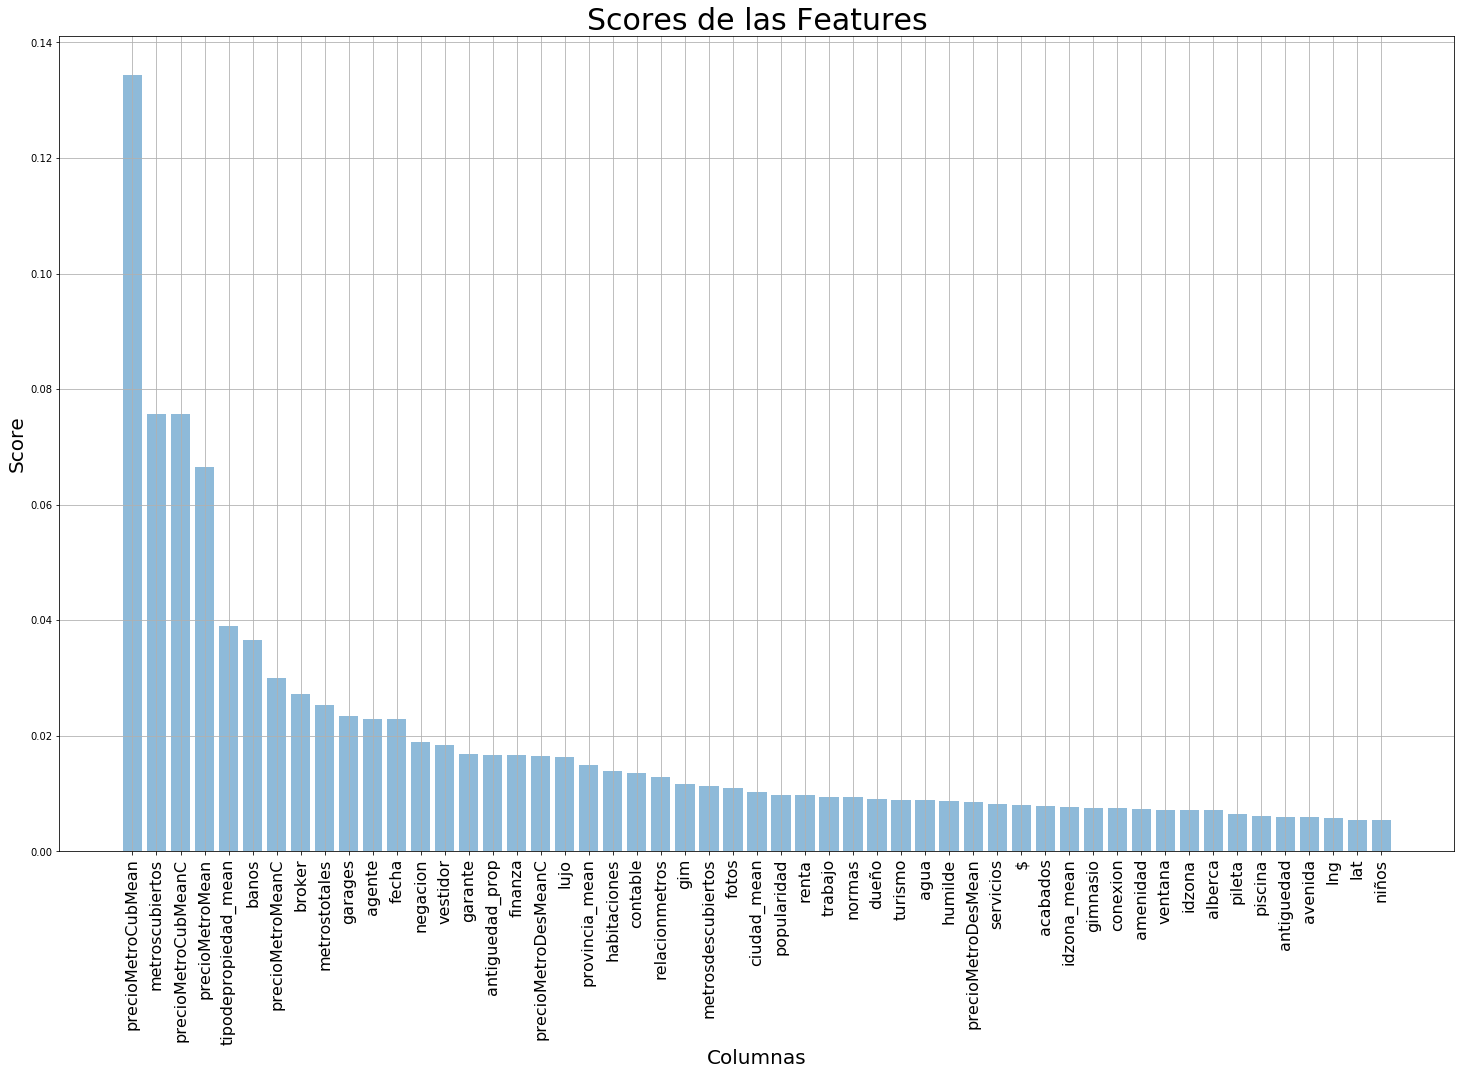

In [16]:
fig, ax = plt.subplots(figsize=(25, 15))


objects = df_scores["Feat"]
y_pos = np.arange(len(objects))
performance = df_scores["Score"]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize =16, rotation = 90)
#plt.savefig('Scores.jpg', bbox_inches='tight')

plt.grid()
plt.title("Scores de las Features", fontsize=30)
plt.xlabel("Columnas", fontsize=20)
plt.ylabel("Score", fontsize=20)
#plt.savefig('/home/ailen-magali/Escritorio/features1.png', bbox_inches = 'tight', pad_inches = 0.1)

plt.show()

v8: 476268.0325589658

v7: 477834.95702371653

v6: 478730.66261742

v5: 482317.6886901042

v4: 486371.91886453686  

v3: 492166.2706188616  

n/e: 492309.7612951079  

In [75]:
def armar_set_3(train):
    
    #Puedo resolver de forma general las que son iguales para train y test
    #es decir, aquellas que no filtran informacion a los de validacion
    
    train = train.drop(['descripcion', 'titulo', 'direccion', 'id'], axis = 1)
    
    #Adiciono servicios
    train['servicios'] = train['piscina'] + train['gimnasio'] + train['usosmultiples']
    
    train['fecha'] = pd.to_datetime(train['fecha']).dt.year
    
    #"Normalizo" la antiguedad
    #train['antiguedad'] = minmax(train['antiguedad'])
    
    #Elimino los residuos
    #train = train.drop(['piscina', 'gimnasio','usosmultiples','escuelascercanas', 
                       # 'centroscomercialescercanos'], axis = 1)
                        
    x_train = train
        
    y_train = x_train["precio"]
    
    df1 = x_train.dropna(subset=['metrostotales'])
    df1['preciometro']=df1['precio']/df1['metrostotales']

    PMM = df1.groupby('idzona').agg({'preciometro': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometro": "precioMetroMean"})

    x_train = x_train.merge(PMM, on='idzona',how='left')


    df1 = x_train.dropna(subset=['metroscubiertos'])
    df1['preciometroCub']=df1['precio']/df1['metroscubiertos']

    PMM = df1.groupby('idzona').agg({'preciometroCub': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometroCub": "precioMetroCubMean"})

    x_train = x_train.merge(PMM, on='idzona',how='left')
    
    df1 = x_train.dropna(subset=['metrosdescubiertos'])
    df1['preciometroDes']=df1['precio']/df1['metrosdescubiertos']

    PMM = df1.groupby('idzona').agg({'preciometroDes': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometroDes": "precioMetroDesMean"})

    x_train = x_train.merge(PMM, on='idzona',how='left')
    
    df1 = x_train.dropna(subset=['metrostotales'])
    df1['preciometro']=df1['precio']/df1['metrostotales']
    
    PMM = df1.groupby('ciudad').agg({'preciometro': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometro": "precioMetroMeanC"})

    x_train = x_train.merge(PMM, on='ciudad',how='left')
    
    
    df1 = x_train.dropna(subset=['metroscubiertos'])
    df1['preciometroCub']=df1['precio']/df1['metroscubiertos']

    PMM = df1.groupby('ciudad').agg({'preciometroCub': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometroCub": "precioMetroCubMeanC"})

    x_train = x_train.merge(PMM, on='ciudad',how='left')
    
    
    df1 = x_train.dropna(subset=['metrosdescubiertos'])
    df1['preciometroDes']=df1['precio']/df1['metrosdescubiertos']

    PMM = df1.groupby('ciudad').agg({'preciometroDes': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometroDes": "precioMetroDesMeanC"})

    x_train = x_train.merge(PMM, on='ciudad',how='left')

    #Calculo los mean target
    x_train_mean = mean_target_encoding(x_train, "provincia", "precio") 
    x_train_mean['precio'] = y_train
    x_train_mean = mean_target_encoding(x_train_mean, "tipodepropiedad", "precio")
    x_train_mean = mean_target_encoding(x_train_mean, "ciudad", "precio")
    x_train = mean_target_encoding(x_train_mean, "idzona", "precio")
    
    backup = x_train_mean
    
    x_train = x_train_mean.drop(["precio","provincia","tipodepropiedad","ciudad"], axis=1)

    
    return x_train, y_train, backup

In [76]:
x_train, y_train, backup = armar_set_3(df)
#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.025,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=3500, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(x_train, y_train)

/home/ailen-magali/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ailen-magali/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ailen-magali/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

[13:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.025,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=3500, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)

In [77]:
df = pd.read_csv("test.csv")

In [79]:
DIRINVALIDAS = set(['Calle','domicilio conocido','calle','CALLE','--','Sin nombre ','1','.','-','x #x','0','...','S/N'])


df.loc[df.direccion.isin(DIRINVALIDAS), 'direccion'] = 0
df.loc[df['direccion'] != 0, 'direccion'] = 1


df['titulo'] = df['titulo'].fillna(value = ".")
df['titulo'] = df['titulo'].apply(normalizar_descripciones)
df['descripcion'] = df['descripcion'].fillna(value = ".")
df['descripcion'] = df['descripcion'].apply(normalizar_descripciones)

df['calefaccion'] = df['titulo'].apply(contar_palabras, palabras=["calefaccion", "calefacción", "calefaccionado", "aireacondicinado",
                    "acondicionado", "estufa","chimenea"]) +df['descripcion'].apply(contar_palabras, palabras=["calefaccion", 
                    "calefacción", "calefaccionado", "aireacondicinado", "acondicionado", "estufa","chimenea"])

df['suite'] = df['titulo'].apply(contar_palabras, palabras=["suite"])+df['descripcion'].apply(contar_palabras, palabras=["suite"])

df['avenida'] = df['titulo'].apply(contar_palabras, palabras=["avenida", "av", "avenidas", "bulevar", 
               "boulevard", "paseo", "vía"])+df['descripcion'].apply(contar_palabras, palabras=["avenida", "av", 
                "avenidas", "bulevar","boulevard", "paseo", "vía"])

df['gim'] = df['titulo'].apply(contar_palabras, palabras=["gimnasio", "gimnásio", "entrenamiento", "gim", "gym", "fit",
            "ejercicio", "gimnasia","atletismo", "cancha"])+df['descripcion'].apply(contar_palabras, palabras=["gimnasio",
            "gimnásio", "entrenamiento", "gim", "gym", "fit","ejercicio", "gimnasia","atletismo", "cancha"])

#df['cochera'] = df['titulo'].apply(contar_palabras, palabras=["cochera", "cocheras", "garage", 
#                "garages", "garaje", "garajes"])+df['descripcion'].apply(contar_palabras, palabras=["cochera", 
#                "cocheras", "garage","garages", "garaje", "garajes"])

df['ubicacion'] = df['titulo'].apply(contar_palabras, palabras=["ubicacion", "ubicación", "locacion", 
                "locación", "localizacion", "localización","ubicado", "ubicada", "centro", "centrico",
                "centrica", "céntrico", "céntrica","central"])+df['descripcion'].apply(contar_palabras, palabras=["ubicacion", "ubicación", "locacion", 
                "locación", "localizacion", "localización","ubicado", "ubicada", "centro", "centrico",
                "centrica", "céntrico", "céntrica","central"])

df['balcon'] = df['titulo'].apply(contar_palabras, palabras=["balcon", "balcón", "terraza", "palco", "mirador", 
            "balconcillo","azotea", "solana"])+df['descripcion'].apply(contar_palabras, palabras=["balcon", "balcón", 
            "terraza", "palco", "mirador", "balconcillo","azotea", "solana"])

df['camaraseg'] = df['titulo'].apply(contar_palabras, palabras=["camara", "cámara", "cámaras", "camaras","seguridad",
                "guardia","seguro","protegido"]) + df['descripcion'].apply(contar_palabras, palabras=["camara", "cámara",
                "cámaras", "camaras","seguridad","guardia","seguro","protegido"])

df['parque'] = df['titulo'].apply(contar_palabras, palabras=["parque", "plaza", "plazoleta", "glorieta","jardin",
            "jardín","patio"])+df['descripcion'].apply(contar_palabras, palabras=["parque", "plaza", "plazoleta", 
            "glorieta","jardin","jardín","patio"])

df['amoblado'] = df['titulo'].apply(contar_palabras, palabras=["muebles", "amoblado", "mueble","decorado",
                "listo"]) + df['descripcion'].apply(contar_palabras, palabras=["muebles", "amoblado", "mueble",
                "decorado","listo"])

df['bañera'] = df['titulo'].apply(contar_palabras, palabras=["bañera", "hidromasaje", "hidro", "tina",
            "jacuzzi","jacuzi","yacuzi"]) + df['descripcion'].apply(contar_palabras, palabras=["bañera", "hidromasaje", 
            "hidro", "tina","jacuzzi","jacuzi","yacuzi"])


#df['estreno'] = df['titulo'].apply(contar_palabras, palabras=["nuevo", "nueva", "estrenar","estreno",
#            "innovador"]) + df['descripcion'].apply(contar_palabras, palabras=["nuevo", "nueva", "estrenar","estreno",
#            "iuevonovador"])

df['transporte'] = df['titulo'].apply(contar_palabras, palabras=["subte", "subterraneo", "subterráneo","metro", 
                "estacion", "estación", "tren","subestacion", "subestación", "ferrocarril","metrobús", "metrobus", 
                "trolebus","trolebús", "bus", "bús"]) + df['descripcion'].apply(contar_palabras, palabras=["subte", 
                "subterraneo", "subterráneo","metro", "estacion", "estación", "tren","subestacion", "subestación", 
                "ferrocarril","metrobús", "metrobus", "trolebus","trolebús", "bus", "bús"])

df['pileta'] = df['titulo'].apply(contar_palabras, palabras=["piscina", "pileta", "nado"])+ df['descripcion'].apply(contar_palabras, palabras=["piscina", "pileta", "nado"])
                                       
df['lujo'] = df['titulo'].apply(contar_palabras, palabras=["lujo", "delujo", "deluxe", "delúxe", "lujosa", "lujoso", 
            "lujosas", "lujosos","exclusivo","vip"]) + df['descripcion'].apply(contar_palabras, palabras=["lujo", 
            "delujo","deluxe", "delúxe", "lujosa", "lujoso", "lujosas", "lujosos","exclusivo","vip"])

df['humilde'] = df['titulo'].apply(contar_palabras, palabras=["humilde", "economico", "economica", 
            "económico", "económica", "barata", "barato", "accesible", "baratillo",
            "baratilla", "rebajado", "ganga", "asequible", "módico", "módica","credito","crédito","oferta","oferton",
            "imperdible"]) + df['descripcion'].apply(contar_palabras, palabras=["humilde", "economico", "economica", 
            "económico", "económica", "barata", "barato", "accesible", "baratillo",
            "baratilla", "rebajado", "ganga", "asequible", "módico", "módica",
            "credito","crédito","oferta","oferton","imperdible"]) 

df['ventana'] = df['titulo'].apply(contar_palabras, palabras=["ventana", "ventanas", 
            "vista", "ventanal","vistas","cristal"]) + df['descripcion'].apply(contar_palabras, palabras=["ventana",
            "ventanas", "vista", "ventanal","vistas","cristal"])

#df['nuevo'] = df['titulo'].apply(contar_palabras, palabras=["reciente", "recien", "recién", "nueva", "nuevo", "nuevas", 
#            "nuevos", "estrenar"]) + df['descripcion'].apply(contar_palabras, palabras=["reciente", "recien", "recién", 
#            "nueva", "nuevo", "nuevas", "nuevos", "estrenar"])

df['luz'] = df['titulo'].apply(contar_palabras, palabras=["luz", "luminoso", "luminosa","claridad", "luminiscencia", 
        "luminosidad", "iluminación","iluminacion"]) + df['descripcion'].apply(contar_palabras, palabras=["luz", 
        "luminoso", "luminosa","claridad", "luminiscencia","luminosidad", "iluminación","iluminacion"])

#df['bueno'] = df['titulo'].apply(contar_palabras, palabras=["bueno", "buena", "buenas", "buenos","excelente", 
#            "excelentes","increible","espectacular"]) + df['descripcion'].apply(contar_palabras, palabras=["bueno", 
#            "buena", "buenas", "buenos","excelente", "excelentes","increible","espectacular"])

df['contable'] = df['titulo'].apply(contar_palabras, palabras=["precio"]) + df['descripcion'].apply(contar_palabras, palabras=["precio"])

#Nuevos Feat

df['agente'] = df['descripcion'].apply(contar_palabras, palabras=["inmobiliaria", "asesoria", "asesoría", "lider", "re/max", "remax"]) \
             + df['titulo'].apply(contar_palabras, palabras=["inmobiliaria", "asesoria", "asesoría", "lider", "re/max", "remax"])

df['garante'] = df['descripcion'].apply(contar_palabras, palabras=["garante", "garantía", "fiador", "garantizador", "avalista", "garantia",
                "defensor", "garantías", "garantes", "codeudor"]) + df['titulo'].apply(contar_palabras, palabras=["garante", 
                "garantía", "fiador", "garantizador", "avalista", "garantia", "defensor", "garantías", "garantes", "codeudor"])

df['finanza'] =  df['descripcion'].apply(contar_palabras, palabras=["credito", "crédito", "prestamo", "préstamo", "cuotas", "pagos", "hipotecario"\
                 ,"amortizable", "aptocredito", "aptocrédito", "apto-credito", "apto-crédito", "aptocredito", "aptocréditp", "ahorro"]) + \
                 df['titulo'].apply(contar_palabras, palabras=["credito", "crédito", "prestamo", "préstamo", "cuotas", "pagos", "hipotecario" \
                 ,"amortizable", "aptocredito", "aptocrédito", "apto-credito", "apto-crédito", "aptocredito", "aptocrédito", "ahorro"]) 

df['turismo'] =  df['descripcion'].apply(contar_palabras, palabras=["playa", "vacaciones", "descanso", "costa", "arena", "mar", "montaña", "monte",
                                                                   "paisaje", "orilla", "rambla", "turista", "turistas", "cordillera", "sierra"])\
                 + df['titulo'].apply(contar_palabras, palabras=["playa", "vacaciones", "descanso", "costa", "arena", "mar", "montaña", "monte",
                                                                   "paisaje", "orilla", "rambla", "turista", "turistas", "cordillera", "sierra"])

df['longitud_desc'] =  df['descripcion'].apply(lambda x: len(x.split()))

#Nuevas de V4

df['longitud_titulo'] = df['titulo'].apply(lambda x: len(x))

df['cant_!'] = df['titulo'].apply(lambda x: x.count('!')) 

df['tranquilidad'] = df['descripcion'].apply(contar_palabras, palabras=["armonía", "armonia", "tranquilo", "tranqui", "tranquilidad", \
                                                                        "paz", "calma", "calmo", "quietud"])\
                 + df['titulo'].apply(contar_palabras, palabras=["armonía", "armonia", "tranquilo", "tranqui", "tranquilidad", \
                                                                        "paz", "calma", "calmo", "quietud"])

df['reparacion'] = df['descripcion'].apply(contar_palabras, palabras=["reparación", "reparacion", "reparando", "reparar", \
                            "construcción", "construccion", "construyendo", "construllendo", "mantenimiento", "averiado", "averiada",
                                                                     "refaccion","refacción","refacciones"])\
                 + df['titulo'].apply(contar_palabras, palabras=["reparación", "reparacion", "reparando", "reparar", \
                            "construcción", "construccion", "construyendo", "construllendo", "mantenimiento", "averiado", "averiada"
                                                                     "refaccion","refacción","refacciones"])

df['mascotas'] = df['descripcion'].apply(contar_palabras, palabras=["mascotas", "mascota", "perros", "perro", "perra", \
                                                "gatos", "gato", "gata", "animal", "animales"])\
                 + df['titulo'].apply(contar_palabras, palabras=["mascotas", "mascota", "perros", "perro", "perra", \
                                                "gatos", "gato", "gata", "animal", "animales"])

df['accesibilidad'] = df['descripcion'].apply(contar_palabras, palabras=["rampa", "discapacitados", "discapacitado", \
                                                "discapacitada", "lisiado", "lisiada", "silla de ruedas", "lastimado", "heridos"])\
                 + df['titulo'].apply(contar_palabras, palabras=["rampa", "discapacitados", "discapacitado", \
                                                "discapacitada", "lisiado", "lisiada", "silla de ruedas", "lastimado", "heridos"])

df['normas'] =  df['descripcion'].apply(contar_palabras, palabras=["norma", "normas", "regla", "reglas", \
                                                "prohibido", "prohibida", "denegado", "denegada", "imposible", \
                                                "ilegal", "legal", "multa", "infraccion", "infracción"])\
                 + df['titulo'].apply(contar_palabras, palabras=["norma", "normas", "regla", "reglas", \
                                                "prohibido", "prohibida", "denegado", "denegada", "imposible", \
                                                "ilegal", "legal", "multa", "infraccion", "infracción"])

df['beneficios'] = df['descripcion'].apply(contar_palabras, palabras=["gratis", "free", "incluido", "incluye", \
                                                "agregado", "gratuito", "gratuitamente", \
                                                "regalo"])\
                 + df['titulo'].apply(contar_palabras, palabras=["gratis", "free", "incluido", "incluye", \
                                                "agregado", "gratuito", "gratuitamente", \
                                                "regalo"])

df['conexion'] = df['descripcion'].apply(contar_palabras, palabras=["wifi", "wi-fi", "internet", "conexión", "conexion", \
                                                                   "señal"])\
                 + df['titulo'].apply(contar_palabras, palabras=["wifi", "wi-fi", "internet", "conexión", "conexion", \
                                                                   "señal"])

df['servicios_desc'] = df['descripcion'].apply(contar_palabras, palabras = ["servicio", "servicios"])

df['metros_desc'] = df['descripcion'].apply(contar_palabras, palabras = ["metros","m2"])

df['acabados'] = df['descripcion'].apply(contar_palabras, palabras = ["acabados","acabado","terminacion","terminación"])

df['plusvalia'] = df['descripcion'].apply(contar_palabras, palabras = ["plusvalia", "plusvalía"])

#Nuevos de V5

df['cocina'] = df['descripcion'].apply(contar_palabras, palabras=['cocina', 'cocinas'])

df['alberca'] = df['descripcion'].apply(contar_palabras, palabras=['alberca'])

df['negacion'] = df['descripcion'].apply(contar_palabras, palabras = ["no"])

df['variospisos'] = df['descripcion'].apply(contar_palabras, palabras = ["escalera","escaleras",
                    "ascensor", "elevador", "escalinata", "gradas", "escalerilla"])

df['vestidor'] = df['descripcion'].apply(contar_palabras, palabras = ["vestidor"])

#Nuevos de V7

df['popularidad'] = df['descripcion'].apply(contar_palabras, palabras=["popular", "famoso", "famosa", "famosos", "populares", \
                                                        "conocido", "conocida", "conocidos"])\
                 + df['titulo'].apply(contar_palabras, palabras=["popular", "famoso", "famosa", "famosos", "populares", \
                                                        "conocido", "conocida", "conocidos"])

df['aeropuerto_cercano'] = df['descripcion'].apply(contar_palabras, palabras=["aeropuerto", "aeropuertos", \
                                                                             "aeródromo", "aerodromo", "estacion"\
                                                                             "estación"])\
                 + df['titulo'].apply(contar_palabras, palabras=["aeropuerto", "aeropuertos", \
                                                                             "aeródromo", "aerodromo", "estacion"\
                                                                             "estación"])

df['traslado'] = df['descripcion'].apply(contar_palabras, palabras=["traslado", "trasladar", "llevamos", \
                                                                   "llevar", "traslada"])\
                 + df['titulo'].apply(contar_palabras, palabras=["traslado", "trasladar", "llevamos", \
                                                                   "llevar", "traslada"])

#df['extranjero'] = df['descripcion'].apply(contar_palabras, palabras=["extranjero", "extranjera", "extranjeros"])\
 #                + df['titulo'].apply(contar_palabras, palabras=["extranjero", "extranjera", "extranjeros"])

df['dueño'] = df['descripcion'].apply(contar_palabras, palabras=["dueño", "dueña", "dueños", "propietario", "propietarios"])\
                 + df['titulo'].apply(contar_palabras, palabras=["dueño", "dueña", "dueños", "propietario", "propietarios"])

df['monoambiente'] = df['descripcion'].apply(contar_palabras, palabras=["monoambiente", "monoambientes"]) \
                     + df['descripcion'].apply(contar_frases, frases=["un ambiente", "unico ambiente", "único ambiente"]) \
                     + df['titulo'].apply(contar_palabras, palabras=["monoambiente", "monoambientes"]) \
                     + df['titulo'].apply(contar_frases, frases=["un ambiente", "unico ambiente", "único ambiente"])

#La renta fija es un tipo de inversión formada por todos los activos financieros en los que el emisor está 
#obligado a realizar pagos en una cantidad y en un período de tiempo previamente establecidos
#Es decir, en la renta fija el emisor garantiza la devolución del capital invertido y una cierta rentabilidad.

df['renta'] =  df['descripcion'].apply(contar_palabras, palabras=["renta", "devolucion", "devolución", \
                                                                 "devolver", "devolvemos", "devuelto", "depósito", \
                                                                 "deposito", "regreso"]) \
              + df['descripcion'].apply(contar_frases, frases=["renta fija", "regreso del depósito", "regreso del deposito"]) \
              + df['titulo'].apply(contar_palabras, palabras=["renta", "devolucion", "devolución", \
                                                                 "devolver", "devolvemos", "devuelto", "depósito", \
                                                                 "deposito", "regreso"]) \
              + df['titulo'].apply(contar_frases, frases=["renta fija", "regreso del depósito", "regreso del deposito"])

df['oportunidad'] = df['descripcion'].apply(contar_palabras, palabras=["opotunidad", "chance", "imperdible", \
                                                                      "aprovecha", "aprovechar"]) \
              + df['descripcion'].apply(contar_frases, frases=["ultima oportunidad", "última oportunidad", \
                                                              "no te lo pierdas", "no lo pierdas", "no dejes pasar"]) \
              + df['titulo'].apply(contar_palabras, palabras=["opotunidad", "chance", "imperdible", \
                                                                      "aprovecha", "aprovechar"]) \
              + df['titulo'].apply(contar_frases, frases=["ultima oportunidad", "última oportunidad", \
                                                              "no te lo pierdas", "no lo pierdas", "no dejes pasar"]) 

df['antiguedad_prop'] = df['descripcion'].apply(contar_palabras, palabras=["antiguo", "antigua", "antigüedad", \
                                                                          "antiguedad", "viejo", "vieja", \
                                                                          "clásico", "clasico", "clásica", "clasica"]) \
              + df['titulo'].apply(contar_palabras, palabras=["antiguo", "antigua", "antigüedad", \
                                                                          "antiguedad", "viejo", "vieja", \
                                                                          "clásico", "clasico", "clásica", "clasica"]) 

df['niños'] = df['descripcion'].apply(contar_palabras, palabras=["niños", "niñas", "niño", "niña", "bebé", \
                                                                  "bebes", "bebe", "hijo", "hija", "hijos", "hijas"]) \
              + df['titulo'].apply(contar_palabras, palabras=["niños", "niñas", "niño", "niña", "bebé", \
                                                                  "bebes", "bebe", "hijo", "hija", "hijos", "hijas"]) 

df['fotos'] = df['descripcion'].apply(contar_palabras, palabras=["foto", "fotos", "imagenes", "imágenes", "imagen", \
                                                                "ilustrado", "ilustración", "ilustracion", "fotografia", \
                                                                "fotografía", "fotografías", "fotografias"]) \
              + df['titulo'].apply(contar_palabras, palabras=["foto", "fotos", "imagenes", "imágenes", "imagen", \
                                                                "ilustrado", "ilustración", "ilustracion", "fotografia", \
                                                                "fotografía", "fotografías", "fotografias"]) 

df['lavadero'] = df['descripcion'].apply(contar_palabras, palabras=["lavadero", "lavadora", "lavarropa", "ropa"]) \
                + df['descripcion'].apply(contar_frases, frases=["cuarto de lavado"]) \
                + df['titulo'].apply(contar_frases, frases=["cuarto de lavado"]) \
              + df['titulo'].apply(contar_palabras, palabras=["lavadero", "lavadora", "lavarropa", "ropa"]) 

#df['camas_separadas'] =  df['descripcion'].apply(contar_frases, frases=["camas separadas", "camas individuales"]) \
#              + df['titulo'].apply(contar_frases, frases=["camas separadas", "camas individuales"])

df['$'] = df['descripcion'].apply(contar_palabras, palabras=["$"]) \
              + df['titulo'].apply(contar_palabras, palabras=["$"])

df['trabajo'] = df['descripcion'].apply(contar_palabras, palabras=["oficina", "oficio", "trabajo", "trabajador"]) \
              + df['titulo'].apply(contar_palabras, palabras=["oficina", "oficio", "trabajo", "trabajador"])

#df['gas'] = df['descripcion'].apply(contar_palabras, palabras=["gas"]) \
#              + df['titulo'].apply(contar_palabras, palabras=["gas"])

df['agua'] = df['descripcion'].apply(contar_palabras, palabras=["cañeria", "cañería", "cañerías", "cañerias", \
                                                               "agua", "aguas", "tubería", "tuberia", "tuberías", "tuberias"]) \
              + df['titulo'].apply(contar_palabras, palabras=["cañeria", "cañería", "cañerías", "cañerias", \
                                                               "agua", "aguas", "tubería", "tuberia", "tuberías", "tuberias"])

df['amenidad'] = df['descripcion'].apply(contar_palabras, palabras=["ameno", "amenidad", "amenidades"]) \
              + df['titulo'].apply(contar_palabras, palabras=["ameno", "amenidad", "amenidades"])

df['broker'] = df['descripcion'].apply(contar_palabras, palabras=["broker", "brokers"]) + \
               df['titulo'].apply(contar_palabras, palabras=["broker", "brokers"])


#df['dia_publicacion'] = df['dia_publicacion'].apply(dia_semana)
#df['dia_publicacion'] = df['fecha'].dt.dayofweek
df['fecha'] = pd.to_datetime(df['fecha'])
df['mes_publicacion'] = df['fecha'].dt.month

In [80]:
df['metrosdescubiertos'] = abs(df['metrostotales']-df['metroscubiertos'])
df['relacionmetros'] = df['metrostotales']/df['metroscubiertos']


servicios                     240000 non-null float64
precioMetroMean               239345 non-null float64
precioMetroCubMean            239233 non-null float64
precioMetroDesMean            239233 non-null float64
provincia_mean                239845 non-null float64
tipodepropiedad_mean          239954 non-null float64
ciudad_mean                   239628 non-null float64
idzona_mean                   211379 non-null float64

precioMetroMean               59801 non-null float64
precioMetroCubMean            59775 non-null float64
precioMetroDesMean            59775 non-null float64
servicios                     60000 non-null float64
provincia_mean                59958 non-null float64
tipodepropiedad_mean          59993 non-null float64
ciudad_mean                   59823 non-null float64
idzona_mean                   46589 non-null float64


In [81]:
x_test = df

In [82]:
#Adiciono servicios
x_test['servicios'] = x_test['piscina'] + x_test['gimnasio'] + x_test['usosmultiples']

df = pd.read_csv("train.csv")
df['metrosdescubiertos'] = abs(df['metrostotales']-df['metroscubiertos'])
df['relacionmetros'] = df['metrostotales']/df['metroscubiertos']

df1 = df.dropna(subset=['metrostotales'])
df1['preciometro']=df1['precio']/df1['metrostotales']

PMM = df1.groupby('idzona').agg({'preciometro': 'mean'})
PMM = PMM.reset_index()
PMM = PMM.rename(columns={"preciometro": "precioMetroMean"})

x_test = x_test.merge(PMM, on='idzona',how='left')
    


df1 = df.dropna(subset=['metroscubiertos'])
df1['preciometroCub']=df1['precio']/df1['metroscubiertos']

PMM = df1.groupby('idzona').agg({'preciometroCub': 'mean'})
PMM = PMM.reset_index()
PMM = PMM.rename(columns={"preciometroCub": "precioMetroCubMean"})

x_test = x_test.merge(PMM, on='idzona',how='left')
    
    
    
df1 = df.dropna(subset=['metrosdescubiertos'])
df1['preciometroDes']=df1['precio']/df1['metrosdescubiertos']

PMM = df1.groupby('idzona').agg({'preciometroDes': 'mean'})
PMM = PMM.reset_index()
PMM = PMM.rename(columns={"preciometroDes": "precioMetroDesMean"})

x_test = x_test.merge(PMM, on='idzona',how='left')




df1 = df.dropna(subset=['metrostotales'])
df1['preciometro']=df1['precio']/df1['metrostotales']
    
PMM = df1.groupby('ciudad').agg({'preciometro': 'mean'})
PMM = PMM.reset_index()
PMM = PMM.rename(columns={"preciometro": "precioMetroMeanC"})

x_test = x_test.merge(PMM, on='ciudad',how='left')
    
    
df1 = df.dropna(subset=['metroscubiertos'])
df1['preciometroCub']=df1['precio']/df1['metroscubiertos']

PMM = df1.groupby('ciudad').agg({'preciometroCub': 'mean'})
PMM = PMM.reset_index()
PMM = PMM.rename(columns={"preciometroCub": "precioMetroCubMeanC"})

x_test = x_test.merge(PMM, on='ciudad',how='left')
    
    
df1 = df.dropna(subset=['metrosdescubiertos'])
df1['preciometroDes']=df1['precio']/df1['metrosdescubiertos']

PMM = df1.groupby('ciudad').agg({'preciometroDes': 'mean'})
PMM = PMM.reset_index()
PMM = PMM.rename(columns={"preciometroDes": "precioMetroDesMeanC"})

x_test = x_test.merge(PMM, on='ciudad',how='left')




#"Normalizo" la antiguedad
#x_train['antiguedad'] = minmax(x_train['antiguedad'])
x_test['fecha'] = pd.to_datetime(x_test['fecha']).dt.year

#Se los asigno a los test (NO LOS CALCULO CON ELLOS!!!!!!)
x_test = mean_target_decoding(x_test, "provincia", backup)
x_test = mean_target_decoding(x_test, "tipodepropiedad", backup)
x_test = mean_target_decoding(x_test, "ciudad", backup)
x_test = mean_target_decoding(x_test, "idzona", backup)

#Elimino los residuos
x_test = x_test.drop([ 'titulo', 'direccion', 'descripcion', 'id'], axis = 1)

########### LIMPIO LOS QUE HICE MEAN ################

x_test.drop(["provincia", "tipodepropiedad","ciudad"], axis=1, inplace = True)

/home/ailen-magali/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ailen-magali/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ailen-magali/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [83]:
prediccion = xgb_model.predict(x_test)

In [84]:
test_original = pd.read_csv("test.csv")
predicciones = test_original.loc[:, ['id','ciudad']]
predicciones.rename(columns = {'ciudad' : 'target'}, inplace = True)
predicciones['target'] = prediccion
predicciones = predicciones.set_index('id')

In [85]:
predicciones.to_csv(r'prediccionXGBFEunifVIII.csv')